# Calculating fold-change IC50 relative to WT
Currently implementing for published IC50s from [Weisblum, et al. (2020)](https://elifesciences.org/articles/61312).

### Set up analysis

In [1]:
import itertools
import math
import os
import re
import warnings

from IPython.display import display, HTML

import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib as mpl
import matplotlib.pyplot as plt
from mizani.formatters import scientific_format

import numpy as np
import pandas as pd
from plotnine import *
import seaborn

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE
import seaborn

import sklearn
import scipy.stats

import yaml

Read in configuration and PSE config:

In [2]:
with open('../config.yaml') as f:
    config = yaml.safe_load(f)

In [3]:
warnings.simplefilter('ignore')

In [4]:
plt.style.use('seaborn-white')
theme_set(theme_seaborn(style='white', context='talk', font='FreeSans', font_scale=1))
#theme_set(theme_seaborn(style='white', context='talk', font='FreeSans', font_scale=1))

In [5]:
def svg_dim(svgfile, dim):
    """Get width or height `dim` of `svgfile` in points."""
    return float(ElementTree.parse(svgfile)
                            .getroot().attrib[dim]
                            .replace('px', '')
                            .replace('pt', '')
                            )

Create results directory

In [6]:
resultsdir='./results/'
os.makedirs(resultsdir, exist_ok=True)

## Read in data

Note that eventually you're going to have to get the escape fractions to do the analysis you want to do here!

In [7]:
escape_fracs_file = os.path.join('..', config['escape_fracs'])
escape_fracs = pd.read_csv(escape_fracs_file).query('library == "average"')

threshold = 'sensitive_max_mut'
strong_escape_sites_file = os.path.join('..', config['strong_escape_sites'])
strong_escape_sites = (pd.read_csv(strong_escape_sites_file)
                       .query('threshold==@threshold')
                       [['condition', 'site', 'threshold']]
                      )

escape_metrics = ['mut_escape_frac_epistasis_model',
                  'site_total_escape_frac_epistasis_model',
                  'site_avg_escape_frac_epistasis_model',
                 ]

ic50s = pd.read_csv(os.path.join('./data', "weisblum_ic50.csv"))

structural_info = (pd.read_csv(os.path.join('./data', "site_contact_escape.csv")))

In [8]:
strong_escape_sites.head()

,condition,site,threshold
776,12C_d152_80,446,sensitive_max_mut
777,12C_d152_80,447,sensitive_max_mut
778,12C_d152_80,448,sensitive_max_mut
779,12C_d152_80,449,sensitive_max_mut
780,12C_d152_80,450,sensitive_max_mut


In [9]:
ic50s['genotype'].unique()

array(['WT_1D7', 'WT_2E1', 'E484K', 'Q493R', 'R346S', 'N440K', 'K444N',
       'K444T', 'V445E', 'V445L', 'V445G', 'N148S', 'N150R', 'K150E',
       'S151P', 'WT', 'R346K', 'V367F', 'N439K', 'K444Q', 'K444R',
       'V445I', 'G446V', 'G446S', 'L455R', 'L455I', 'L455F', 'F456V',
       'A475V', 'A475D', 'G476A', 'G476S', 'T478I', 'V483I', 'V483A',
       'V483F', 'E484Q', 'E484A', 'E484D', 'F490S', 'F490L', 'Q493K',
       'Q493L', 'S494P', 'N501Y', 'V503F'], dtype=object)

In [10]:
# columns are figure,virus_type,antibody,genotype,plot_x,plot_y,IC50,ic50_nt50

# group by figure, virus_type,antibody
wildtype_ic50 = (ic50s
                 .query('genotype.str.contains("WT")')
                 .groupby(['figure', 'virus_type', 'antibody'])
                 # add column that is the average of WT for each group
                 ['IC50']
                 .mean()
                 .reset_index()
                 .rename(columns={'IC50':'wildtype_IC50'})
                )

# then merge back with group
foldchange = (ic50s
              .merge(wildtype_ic50,
                     how='left',
                     on=['figure', 'virus_type', 'antibody'],
                     #validate='one_to_many'
                    )
              .drop(columns=['plot_x', 'plot_y'])
              # then calculate fold change relative to wildtype average
              .assign(full_genotype=lambda x: x.genotype,
                      fold_change=lambda x: x['IC50'] / x['wildtype_IC50'],
                      is_wildtype=lambda x: x['genotype'].isin(['WT', 'WT_1D7', 'WT_2E1']),
                      #site=lambda x: x['genotype']
                     )
             )
foldchange['site'] = foldchange['genotype'].str.slice(1, 4)
foldchange['wildtype'] = foldchange['genotype'].str.slice(0, 1)
foldchange['mutation'] = foldchange['genotype'].str.slice(4, 5)


foldchange['genotype'] = foldchange['genotype'].replace(regex=r'WT_1D7', value='WT')
foldchange['genotype'] = foldchange['genotype'].replace(regex=r'WT_2E1', value='WT')

# also assign column 'domain' to be 'NTD' if site is in ['148', '150', '151']
# foldchange['domain'] = np.where(lambda x: foldchange['site'].isin ['148', '150', '151'], 'NTD', 'RBD')
foldchange['domain'] =['NTD' if x in ['148', '150', '151'] else 'RBD' for x in foldchange['site']]

foldchange = (foldchange.merge((structural_info[['antibody', 'site', 'site_category']]
                                .assign(site=lambda x: x['site'].astype(str))
                               ),
                               how='left',
                               on=['antibody', 'site']
                              )
              .assign(site_category=lambda x: pd.Categorical(x['site_category'],
                                                             ['contact', 'proximal', 'distal', 'unresolved', 'other'], 
                                                             ordered=True
                                                            )
                          )
              .fillna('other')
             )

foldchange.head(5)
# foldchange.sort_values('site')['genotype']

,figure,virus_type,antibody,genotype,IC50,ic50_nt50,IC50_bound,wildtype_IC50,full_genotype,fold_change,is_wildtype,site,wildtype,mutation,domain,site_category
0,4B,VSV,C121,WT,6.969134,IC50,False,5.400258,WT_1D7,1.290519,True,T_1,W,D,RBD,other
1,4B,VSV,C121,WT,1.539197,IC50,False,5.400258,WT_1D7,0.285023,True,T_1,W,D,RBD,other
2,4B,VSV,C121,WT,4.491569,IC50,False,5.400258,WT_2E1,0.831732,True,T_2,W,E,RBD,other
3,4B,VSV,C121,WT,8.601130,IC50,False,5.400258,WT_2E1,1.592726,True,T_2,W,E,RBD,other
4,4B,VSV,C121,E484K,9568.965183,IC50,True,5.400258,E484K,1771.946020,False,484,E,K,RBD,contact


Plotting fold change IC50 for VSV pseudovirus neuts:
['N148S' 'N150R' 'K150E' 'S151P' 'R346S' 'N440K' 'K444T' 'K444N' 'V445E'
 'V445L' 'V445G' 'E484K' 'Q493R' 'WT']
Plotting fold change IC50 for lenti pseudovirus neuts:
['R346K' 'R346S' 'V367F' 'N439K' 'N440K' 'K444Q' 'K444R' 'K444N' 'V445L'
 'V445I' 'V445E' 'G446S' 'G446V' 'L455R' 'L455I' 'L455F' 'F456V' 'A475V'
 'A475D' 'G476A' 'G476S' 'T478I' 'V483A' 'V483F' 'V483I' 'E484D' 'E484Q'
 'E484A' 'F490L' 'F490S' 'Q493R' 'Q493L' 'Q493K' 'S494P' 'N501Y' 'V503F'
 'WT']


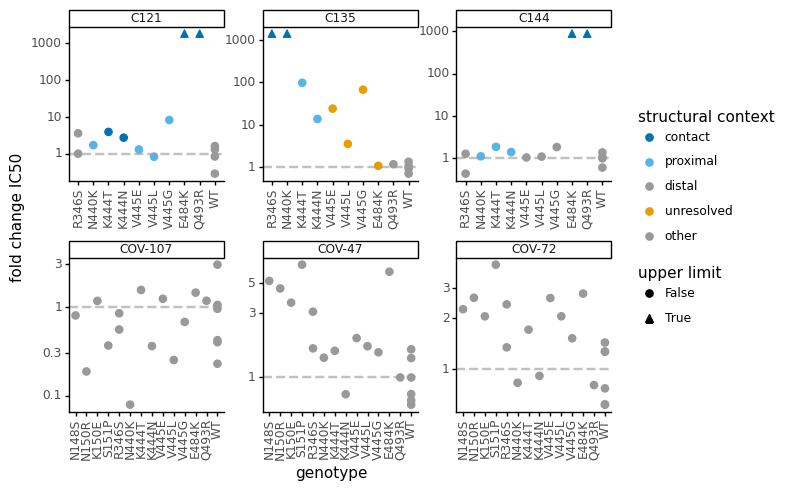

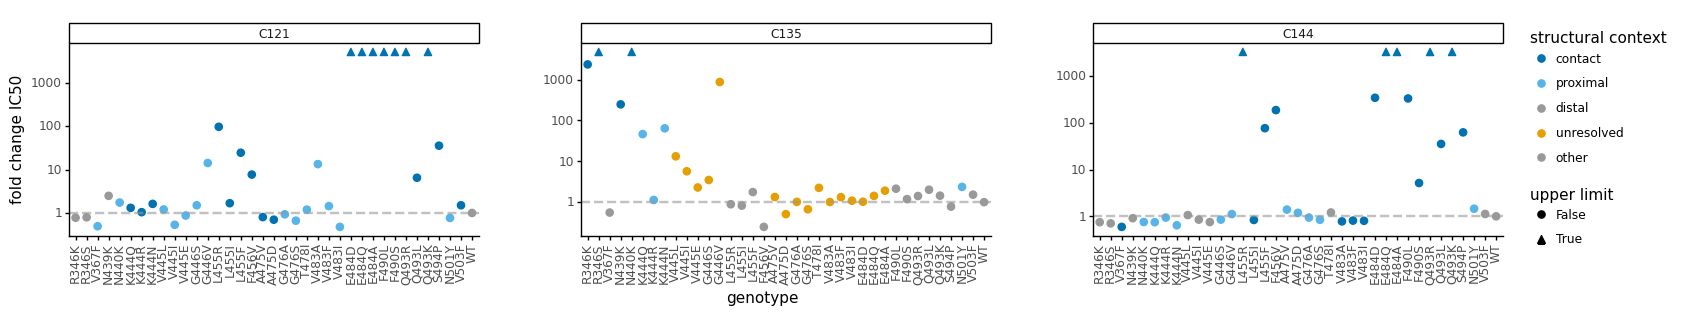

In [11]:
for virus_type in foldchange['virus_type'].unique():
    print(f'Plotting fold change IC50 for {virus_type} pseudovirus neuts:')
    ncol=3
    nrow=math.ceil(foldchange.query('virus_type==@virus_type')['antibody'].nunique()/ncol)
    
    genotype_order=foldchange.query('virus_type==@virus_type').sort_values('site')['genotype'].unique()
    print(genotype_order)
    
    df = (foldchange.query('virus_type==@virus_type'))
    df = (df.assign(genotype = pd.Categorical(df['genotype'], 
                                         categories=genotype_order, 
                                         ordered=True)))
    
    p = (ggplot(df) +
         aes('genotype', 'fold_change', color='site_category', shape='IC50_bound') +
         geom_point(size=2.5) +
         scale_y_log10(name='fold change IC50') +
         facet_wrap('~antibody', scales='free', ncol=ncol) +
         theme_classic() +
         theme(axis_text_x=element_text(angle=90),
               figure_size=(0.5*foldchange.query('virus_type==@virus_type')['genotype'].nunique(), nrow*2.5),
               subplots_adjust={'hspace':0.5, 'wspace':0.25},
               ) +
         geom_hline(yintercept=1, linetype='dashed', size=1,
                    alpha=0.6, color=CBPALETTE[0]) +
         scale_color_manual(values=[CBPALETTE[5], CBPALETTE[2], CBPALETTE[0], CBPALETTE[1], CBPALETTE[0]],
                            name='structural context') +
         scale_shape_manual(values=['o','^'], name='upper limit')
         )

    _ = p.draw()
    p.save(f'{resultsdir}/foldchange_{virus_type}.pdf')

Make same plot for sera only and color RBD (black) vs. NTD (gray)

Make same plots but color if site of strong escape

In [12]:
# dictionary mapping serum naming
sera_names = {'COV-021_500':'COV-21', 
              'COV-047_200':'COV-47', 
              'COV-057_50':'COV-57', 
              'COV-072_200':'COV-72', 
              'COV-107_80':'COV-107',
              'C121_400':'C121',
              'C144_400':'C144',
              'C135_400':'C135'
             }

samples = ['C121', 'C144', 'C135', 'COV-47', 'COV-107', 'COV-72']

strong_escape_sites_df = (strong_escape_sites.replace(sera_names)
                          .query('condition in @samples')
                          .rename(columns={'condition':'antibody',})
                          .assign(strong_escape_site=True)
                         )

strong_escape_fc = (foldchange
             .merge(strong_escape_sites_df.assign(site=lambda x: x['site'].astype(str)),
                    how='left',
                    on=['antibody','site']
                   )
             .fillna({'strong_escape_site':False})
            )

Plotting fold change IC50 for VSV pseudovirus neuts:
['N148S' 'N150R' 'K150E' 'S151P' 'R346S' 'N440K' 'K444T' 'K444N' 'V445E'
 'V445L' 'V445G' 'E484K' 'Q493R' 'WT']
Plotting fold change IC50 for lenti pseudovirus neuts:
['R346K' 'R346S' 'V367F' 'N439K' 'N440K' 'K444Q' 'K444R' 'K444N' 'V445L'
 'V445I' 'V445E' 'G446S' 'G446V' 'L455R' 'L455I' 'L455F' 'F456V' 'A475V'
 'A475D' 'G476A' 'G476S' 'T478I' 'V483A' 'V483F' 'V483I' 'E484D' 'E484Q'
 'E484A' 'F490L' 'F490S' 'Q493R' 'Q493L' 'Q493K' 'S494P' 'N501Y' 'V503F'
 'WT']


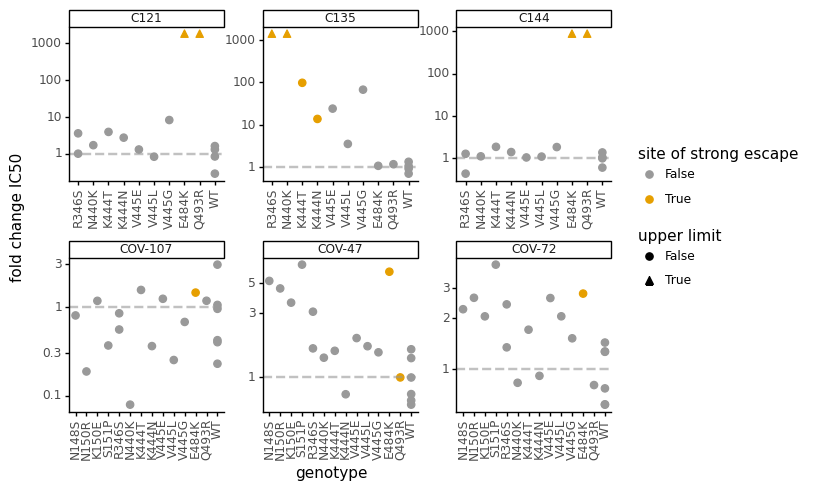

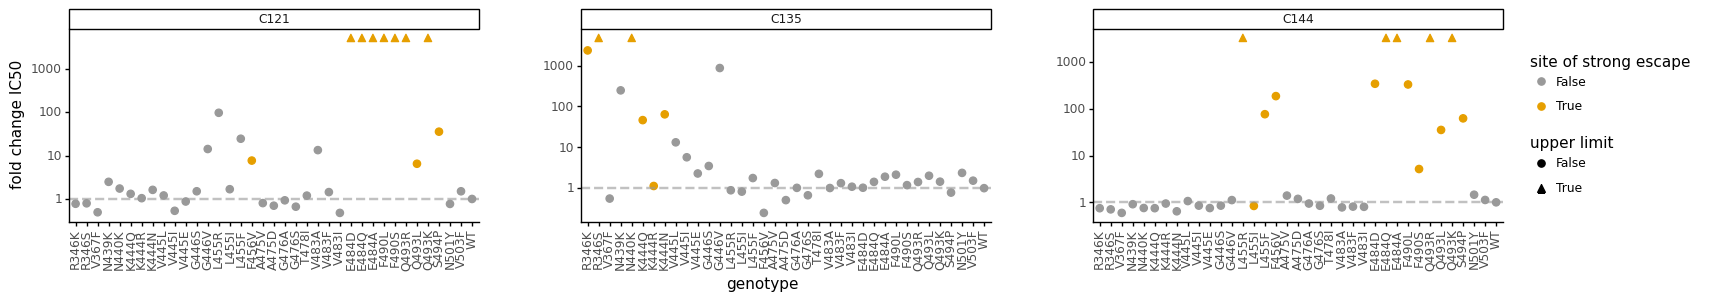

In [13]:
for virus_type in foldchange['virus_type'].unique():
    print(f'Plotting fold change IC50 for {virus_type} pseudovirus neuts:')
    ncol=3
    nrow=math.ceil(foldchange.query('virus_type==@virus_type')['antibody'].nunique()/ncol)
    
    genotype_order=foldchange.query('virus_type==@virus_type').sort_values('site')['genotype'].unique()
    print(genotype_order)
    
    df = (strong_escape_fc.query('virus_type==@virus_type'))
    df = (df.assign(genotype = pd.Categorical(df['genotype'], 
                                         categories=genotype_order, 
                                         ordered=True)))
    
    p = (ggplot(df) +
         aes('genotype', 'fold_change', color='strong_escape_site', shape='IC50_bound') +
         geom_point(size=2.5) +
         scale_y_log10(name='fold change IC50') +
         facet_wrap('~antibody', scales='free', ncol=ncol) +
         theme_classic() +
         theme(axis_text_x=element_text(angle=90),
               figure_size=(0.5*foldchange.query('virus_type==@virus_type')['genotype'].nunique(), nrow*2.5),
               subplots_adjust={'hspace':0.5, 'wspace':0.25},
               ) +
         geom_hline(yintercept=1, linetype='dashed', size=1,
                    alpha=0.6, color=CBPALETTE[0]) +
         scale_color_manual(values=[CBPALETTE[0], CBPALETTE[1]],
                            name='site of strong escape') +
         scale_shape_manual(values=['o','^'], name='upper limit')
         )

    _ = p.draw()
    p.save(f'{resultsdir}/foldchange_{virus_type}_colorstrongescape.pdf')

['N148S' 'N150R' 'K150E' 'S151P' 'R346S' 'N440K' 'K444T' 'K444N' 'V445E'
 'V445L' 'V445G' 'E484K' 'Q493R' 'WT']


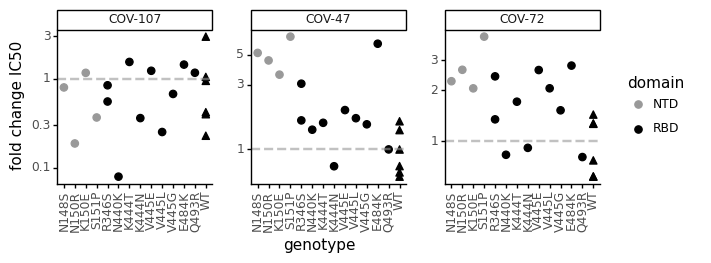

In [14]:
sera = ['COV-107','COV-72','COV-47']

genotype_order=foldchange.query('antibody in @sera').sort_values('site')['genotype'].unique()
print(genotype_order)

df = (foldchange.query('antibody in @sera'))
df = (df.assign(genotype = pd.Categorical(df['genotype'], 
                                     categories=genotype_order, 
                                     ordered=True)))

p = (ggplot(df) +
     aes('genotype', 'fold_change', color='domain', shape='is_wildtype') +
     geom_point(size=2.5) +
     scale_y_log10(name='fold change IC50') +
     facet_wrap('~antibody', scales='free', ncol=ncol) +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.5*foldchange.query('antibody in @sera')['genotype'].nunique(), nrow*2),
           subplots_adjust={'hspace':0.5, 'wspace':0.25},
           ) +
     geom_hline(yintercept=1, linetype='dashed', size=1,
                alpha=0.6, color=CBPALETTE[0]) +
     scale_color_manual(values=[CBPALETTE[0], '#000000'],
                        name='domain')+
     scale_shape_manual(values=['o','^'], guide=False)
     )

_ = p.draw()
p.save(f'{resultsdir}/foldchange_sera_NTD.pdf')

## Make plots comparing mutation escape fraction with fold-change IC50.
Do this at the mutation and site levels.
Also make sure that sera are renamed to drop the extra "0" (i.e., COV-047 should be COV-47).

In [15]:
# dictionary mapping serum naming
sera_names = {'COV-021_500':'COV-21', 
              'COV-047_200':'COV-47', 
              'COV-057_50':'COV-57', 
              'COV-072_200':'COV-72', 
              'COV-107_80':'COV-107',
              'C121_400':'C121',
              'C144_400':'C144',
              'C135_400':'C135'
             }

samples = ['C121', 'C144', 'C135', 'COV-47', 'COV-107', 'COV-72']

vsv_selections = (pd.DataFrame.from_dict(
    {'antibody': ['C121','C121','C121','C135','C135','C135','C135','C144','C144','C144'],
     'mutant': ['E484K','F490L','Q493K','R346M','R346K','R346S','N440K','E484K','Q493K','Q493R']
    })
                  .assign(vsv_selection=True)
                 )

escape_fracs_df = (escape_fracs
                   .replace(sera_names)
                   .query('selection in @samples')
                   [['selection', 'label_site', 'wildtype', 'mutation', 
                     'mut_escape_frac_epistasis_model', 
                     'site_total_escape_frac_epistasis_model', 
                     'site_avg_escape_frac_epistasis_model']
                   ]
                   .rename(columns={'selection':'antibody', 
                                    'label_site': 'site', 
                                    'mut_escape_frac_epistasis_model':'mut_escape',
                                    'site_total_escape_frac_epistasis_model':'site_total_escape',
                                    'site_avg_escape_frac_epistasis_model':'site_avg_escape'
                                   }
                          )
                   .assign(mutant=lambda x: x['wildtype'] + x['site'].astype(str) + x['mutation'],
                           site_label=lambda x: x['wildtype'] + x['site'].astype(str),
                           site=lambda x: x['site'].astype(int)
                          )
                  )

strong_escape_sites_df = (strong_escape_sites.replace(sera_names)
                          .query('condition in @samples')
                          .rename(columns={'condition':'antibody',})
                          .assign(strong_escape_site=True)
                         )

escape_fc = (foldchange
             [['antibody','genotype', 'wildtype', 'site', 'mutation', 'IC50_bound','fold_change','virus_type', 'site_category']]
             .rename(columns={'genotype':'mutant'})
             .replace({'lenti':'lentivirus'})
             .query('mutant!="WT"')
             .assign(site=lambda x: x['site'].astype(int))
             .merge(escape_fracs_df,
                    how='inner', 
                    on=['antibody', 'mutant', 'wildtype', 'site', 'mutation'],
                    validate='many_to_one'
                   )
             .merge(vsv_selections,
                   how='left',
                   on=['antibody', 'mutant'])
             .fillna({'vsv_selection':False})
             .merge(strong_escape_sites_df,
                    how='left',
                    on=['antibody','site']
                   )
             .fillna({'strong_escape_site':False})
            )
escape_fc.head()

,antibody,mutant,wildtype,site,mutation,IC50_bound,fold_change,virus_type,site_category,mut_escape,site_total_escape,site_avg_escape,site_label,vsv_selection,threshold,strong_escape_site
0,C121,E484K,E,484,K,True,1771.946020,VSV,contact,0.999800,17.17000,0.903500,E484,True,sensitive_max_mut,True
1,C121,Q493R,Q,493,R,True,1768.808761,VSV,contact,0.522200,1.79100,0.099480,Q493,False,sensitive_max_mut,True
2,C121,Q493R,Q,493,R,True,5108.338542,lentivirus,contact,0.522200,1.79100,0.099480,Q493,False,sensitive_max_mut,True
3,C121,R346S,R,346,S,False,3.523036,VSV,distal,0.001716,0.03268,0.001816,R346,False,NaN,False
4,C121,R346S,R,346,S,False,0.990573,VSV,distal,0.001716,0.03268,0.001816,R346,False,NaN,False


### Plots look best at the mutation level for the mAbs, and at the site level for sera

Saving to ./results//ic50_vs_escape_mabs.pdf


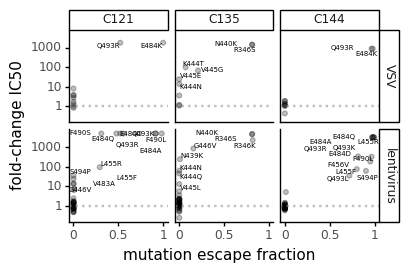

In [16]:
#for metric in ['mut_escape', 'site_total_escape']:

# label all mutations with escape >0.1 or fold-change >10
mut_escape_min=0.075
fold_change_min=10

antibodies = ['C121', 'C135', 'C144']
sera = ['COV-107','COV-72','COV-47']
ab_sera = antibodies + sera

label_df = (escape_fc
            .query(f"(mut_escape>{mut_escape_min} or fold_change>{fold_change_min})")
#             .assign(antibody=lambda x: pd.Categorical(x['antibody'], antibodies, ordered=True))
           )

# make mutation level plots for mabs
p = (ggplot(escape_fc
            .query('antibody in @antibodies')
            .assign(antibody=lambda x: pd.Categorical(x['antibody'], antibodies, ordered=True))
           ) +
     aes(x='mut_escape', y='fold_change') +
     geom_jitter(alpha=0.25) +
     geom_hline(yintercept=1, linetype='dotted', size=1, alpha=0.6, color=CBPALETTE[0]) +
     geom_text(data=(escape_fc
                     .query('antibody in @antibodies')
                     .assign(antibody=lambda x: pd.Categorical(x['antibody'], antibodies, ordered=True))
                     .query(f"(mut_escape>{mut_escape_min} or fold_change>{fold_change_min})")
                    ),
               mapping=aes(label='mutant'),
               size=5,
               adjust_text={'expand_points': (1.05, 1.05),
                            'expand_text': (1.05, 1.05)},
               ) +
     facet_grid('virus_type~antibody') +
     scale_x_continuous(breaks=[0, 0.5, 1], name='mutation escape fraction') +
     scale_y_log10(name='fold-change IC50') +
     theme_classic() +
     theme(figure_size=(4,2.5),
          ) 
    )

_ = p.draw()

# plotfile = f'{resultsdir}/ic50_vs_escape_mabs_{virus}.pdf'
plotfile = f'{resultsdir}/ic50_vs_escape_mabs.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

Saving to ./results//ic50_vs_escape_mabs_nolabs.pdf


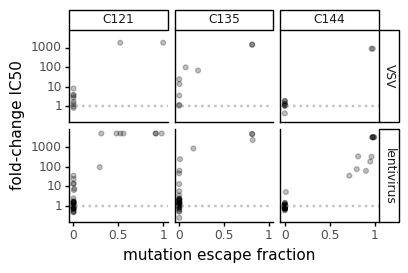

In [17]:
antibodies = ['C121', 'C135', 'C144']

# make mutation level plots for mabs
p = (ggplot(escape_fc
            .query('antibody in @antibodies')
            .assign(antibody=lambda x: pd.Categorical(x['antibody'], antibodies, ordered=True))
           ) +
     aes(x='mut_escape', y='fold_change') +
     geom_jitter(alpha=0.25) +
     geom_hline(yintercept=1, linetype='dotted', size=1, alpha=0.6, color=CBPALETTE[0]) +
     facet_grid('virus_type~antibody') +
     scale_x_continuous(breaks=[0, 0.5, 1], name='mutation escape fraction') +
     scale_y_log10(name='fold-change IC50') +
     theme_classic() +
     theme(figure_size=(4,2.5),
          )
    )

_ = p.draw()

# plotfile = f'{resultsdir}/ic50_vs_escape_mabs_{virus}.pdf'
plotfile = f'{resultsdir}/ic50_vs_escape_mabs_nolabs.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

Saving to ./results//ic50_vs_mut_escape_mabs.pdf
Saving to ./results//ic50_vs_site_total_escape_mabs.pdf


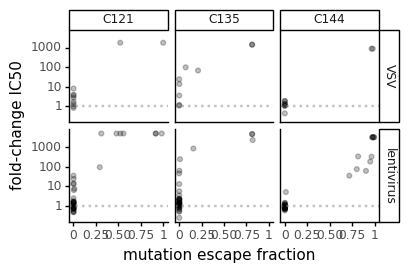

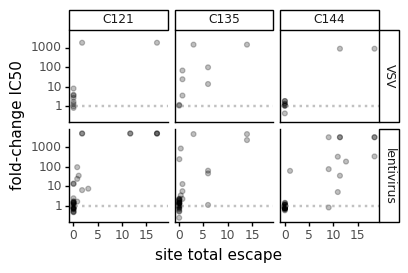

In [18]:
# no labels
for metric in ['mut_escape', 'site_total_escape']:
    xlab = 'mutation escape fraction' if metric == 'mut_escape' else 'site total escape'

    antibodies = ['C121', 'C135', 'C144']

    # make mutation level plots for mabs
    p = (ggplot(escape_fc
                .query('antibody in @antibodies')
                .assign(antibody=lambda x: pd.Categorical(x['antibody'], antibodies, ordered=True))
               ) +
         aes(x=metric, y='fold_change') +
         geom_jitter(alpha=0.25) +
         geom_hline(yintercept=1, linetype='dotted', size=1, alpha=0.6, color=CBPALETTE[0]) +
         facet_grid('virus_type~antibody') +
         scale_x_continuous(name=f'{xlab}') +
         scale_y_log10(name='fold-change IC50') +
         theme_classic() +
         theme(figure_size=(4,2.5),
              ) 
        )

    _ = p.draw()

    # plotfile = f'{resultsdir}/ic50_vs_escape_mabs_{virus}.pdf'
    plotfile = f'{resultsdir}/ic50_vs_{metric}_mabs.pdf'
    print(f"Saving to {plotfile}")
    p.save(plotfile, verbose=False)

Saving to ./results//ic50_vs_escape_sera.pdf


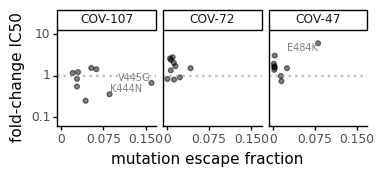

In [19]:
# make site level plots for sera
p = (ggplot(escape_fc
            .query('antibody in @sera')
            .assign(antibody=lambda x: pd.Categorical(x['antibody'], sera, ordered=True))
           ) +
     aes(x='mut_escape', y='fold_change') +
     geom_jitter(alpha=0.5) +
     geom_hline(yintercept=1, linetype='dotted', size=1, alpha=0.6, color=CBPALETTE[0]) +
     facet_wrap('~antibody', ncol=3) +
     scale_x_continuous(breaks=[0, 0.075, 0.15], name='mutation escape fraction') +
     scale_y_log10(name='fold-change IC50', 
                   limits=[escape_fc.query('antibody in @sera')['fold_change'].min(), 
                           10
                          ]
                  ) +
     geom_text(data=(escape_fc
                     .query('antibody in @sera')
                     .assign(antibody=lambda x: pd.Categorical(x['antibody'], sera, ordered=True))
                     .query(f"(mut_escape>{mut_escape_min})")
                    ),
               mapping=aes(label='mutant'),
               color='#808080',
               size=7,
               adjust_text={'expand_points': (1.05, 1.05),
                            'expand_text': (1.05, 1.05)},
               ) +
     theme_classic() +
     theme(figure_size=(4,1.25),
           #subplots_adjust={'hspace':0.5, 'wspace':0.25},
          )  
    )

_ = p.draw()

plotfile = f'{resultsdir}/ic50_vs_escape_sera.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)